In [34]:
from google.colab import drive
drive.mount('/home/MyDrive', force_remount=True)

Mounted at /home/MyDrive


In [35]:
# import os

# path = '/home/myDrive/MyDrive/res/res18.txt'
# acc = []
# file_18 = open(path, mode='w')
# for i in range(5):
#   acc.append(i)
#   file_18.write(str(i))
#   file_18.write(',')
# # file_18.write('jf')
# !cat "$path"
# file_18.close()

In [36]:
import numpy as np
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as T
import torch.nn.functional as F
import torchvision.datasets as dset
from torch.utils.data import sampler
import time


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channel, out_channel, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channel, out_channel, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel)
        self.conv2 = nn.Conv2d(out_channel, out_channel, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.shortcut = nn.Sequential()
        # 经过处理后的x要与x的维度相同(尺寸和深度)
        # 如果不相同，需要添加卷积+BN来变换为同一维度
        if stride != 1 or out_channel != self.expansion * in_channel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, self.expansion * out_channel,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channel)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)  # ResBlock
        out = F.relu(out)
        return out


# 用于ResNet50,101和152的残差块，用的是1x1+3x3+1x1的卷积
class Bottleneck(nn.Module):
    # 前面1x1和3x3卷积的filter个数相等，最后1x1卷积是其expansion倍
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes,
                               kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])


def ResNet34():
    return ResNet(BasicBlock, [3, 4, 6, 3])


def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


def ResNet101():
    return ResNet(Bottleneck, [3, 4, 23, 3])


def ResNet152():
    return ResNet(Bottleneck, [3, 8, 36, 3])


# train
def train(model, device, loader_train, loader_val, param, loss_file_path, acc_file_path):
    model = model.to(device).train()
    criterion = nn.CrossEntropyLoss()
    optimizar= torch.optim.Adam(model.parameters(), lr=param['lr'])
    total_step = len(loader_train)

    loss_file = open(loss_file_path, mode='w')
    acc_file = open(acc_file_path, 'w')

    losses = []
    accs = []

    time_start = time.time()
    for epoch in range(param['epochs']):
        for i, (image, label) in enumerate(loader_train):
            image = image.to(device, dtype=torch.float32)
            label = label.to(device, dtype=torch.long)

            scores = model(image)
            loss = criterion(scores, label)

            optimizar.zero_grad()
            loss.backward()
            optimizar.step()

            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                      .format(epoch + 1, param['epochs'], i + 1, total_step, loss.item()))
                # loss = loss.item()
                losses.append(loss.item())
                loss_w = str(loss.item())
                loss_file.write(loss_w)
                loss_file.write('\n')

        with torch.no_grad():
            correct, total = 0, 0
            model = model.eval()
        # test!
            for image, label in loader_val:
                image = image.to(device, dtype=torch.float32)
                label = label.to(device, dtype=torch.long)
                output = model(image)
                _, pred = torch.max(output.data, 1)
                total += label.size(0)
                correct += (label == pred).sum().item()

            accuracy = correct/total
            accs.append(accuracy)
            acc_file.write(str(accuracy))
            acc_file.write('\n')
            print('Accuracy of the network on the test images: {:.2f} %'.format(100*accuracy))
        model = model.train()
    time_end = time.time()

    print('Time: {:.2f}'.format(time_end-time_start))
    return losses, accs, time_end-time_start

In [37]:
#  dataloader!
NUM = 49000
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
cifar10_train = dset.CIFAR10('./datasets', train=True, download=True,
                             transform=transform)
loader_train = DataLoader(cifar10_train, batch_size=64,
                          sampler=sampler.SubsetRandomSampler(range(NUM)))
cifar10_val = dset.CIFAR10('./datasets', train=True, download=True,
                           transform=transform)
loader_val = DataLoader(cifar10_val, batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM, 50000)))
cifar10_test = dset.CIFAR10('./datasets', train=False, download=True,
                            transform=transform)
loader_test = DataLoader(cifar10_test, batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [38]:
param = {}
param['lr'] = 1e-5
param['epochs'] = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# ResNet18

In [39]:
print('Now: ResNet18')
model18 = ResNet18()
loss18_path = '/home/MyDrive/MyDrive/res/loss18.txt'
acc18_path = '/home/MyDrive/MyDrive/res/acc18.txt'
loss18, acc18, time18 = train(model18, device, loader_train, loader_val, param, loss18_path, acc18_path)

Now: ResNet18
Epoch [1/10], Step [100/766], Loss: 1.6911
Epoch [1/10], Step [200/766], Loss: 1.6556
Epoch [1/10], Step [300/766], Loss: 1.5035
Epoch [1/10], Step [400/766], Loss: 1.6162
Epoch [1/10], Step [500/766], Loss: 1.4638
Epoch [1/10], Step [600/766], Loss: 1.3998
Epoch [1/10], Step [700/766], Loss: 1.3071
Accuracy of the network on the test images: 51.20 %
Epoch [2/10], Step [100/766], Loss: 1.1569
Epoch [2/10], Step [200/766], Loss: 1.3596
Epoch [2/10], Step [300/766], Loss: 1.2351
Epoch [2/10], Step [400/766], Loss: 1.1464
Epoch [2/10], Step [500/766], Loss: 1.2714
Epoch [2/10], Step [600/766], Loss: 1.2378
Epoch [2/10], Step [700/766], Loss: 1.1468
Accuracy of the network on the test images: 59.10 %
Epoch [3/10], Step [100/766], Loss: 0.9574
Epoch [3/10], Step [200/766], Loss: 0.9971
Epoch [3/10], Step [300/766], Loss: 0.7964
Epoch [3/10], Step [400/766], Loss: 0.9131
Epoch [3/10], Step [500/766], Loss: 0.9250
Epoch [3/10], Step [600/766], Loss: 0.8882
Epoch [3/10], Step [70

In [40]:
with torch.no_grad():
  correct = 0
  total = 0
  model18 = model18.eval()
  for images, labels in loader_test:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model18(images)
    _, predict = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predict == labels).sum().item()

  accuracy = correct / total
  test_acc_path = '/home/MyDrive/MyDrive/res/test_acc'
  test_acc = open(test_acc_path, 'w')
  test_acc.write('ResNet18 Acc:')
  test_acc.write(str(accuracy))
  test_acc.close()
  print('ResNet18：Accuracy of the network on the test images: {} %'.format(100 * accuracy))

ResNet18：Accuracy of the network on the test images: 59.12 %


# ResNet34

In [41]:
print('Now: ResNet34')
model34 = ResNet34()
loss34_path = '/home/MyDrive/MyDrive/res/loss34.txt'
acc34_path = '/home/MyDrive/MyDrive/res/acc34.txt'
loss34, acc34, time34 = train(model34, device, loader_train, loader_val, param, loss34_path, acc34_path)
# loss18, acc18, time18 = train(model18, device, loader_train, loader_val, param, loss18_path, acc18_path)

Now: ResNet34
Epoch [1/10], Step [100/766], Loss: 1.9536
Epoch [1/10], Step [200/766], Loss: 1.7151
Epoch [1/10], Step [300/766], Loss: 1.6093
Epoch [1/10], Step [400/766], Loss: 1.1652
Epoch [1/10], Step [500/766], Loss: 1.4371
Epoch [1/10], Step [600/766], Loss: 1.5572
Epoch [1/10], Step [700/766], Loss: 1.3282
Accuracy of the network on the test images: 50.80 %
Epoch [2/10], Step [100/766], Loss: 1.3587
Epoch [2/10], Step [200/766], Loss: 1.3249
Epoch [2/10], Step [300/766], Loss: 1.3705
Epoch [2/10], Step [400/766], Loss: 1.3367
Epoch [2/10], Step [500/766], Loss: 1.2231
Epoch [2/10], Step [600/766], Loss: 1.3120
Epoch [2/10], Step [700/766], Loss: 1.2890
Accuracy of the network on the test images: 57.60 %
Epoch [3/10], Step [100/766], Loss: 1.0646
Epoch [3/10], Step [200/766], Loss: 0.9330
Epoch [3/10], Step [300/766], Loss: 1.0013
Epoch [3/10], Step [400/766], Loss: 0.9333
Epoch [3/10], Step [500/766], Loss: 1.1003
Epoch [3/10], Step [600/766], Loss: 1.0609
Epoch [3/10], Step [70

In [42]:
# 29.23GB

In [43]:
with torch.no_grad():
  correct = 0
  total = 0
  model34 = model34.eval()
  for images, labels in loader_test:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model34(images)
    _, predict = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predict == labels).sum().item()

  accuracy = correct / total
  test_acc_path = '/home/MyDrive/MyDrive/res/test_acc'
  test_acc = open(test_acc_path, 'w')
  test_acc.write('ResNet34 Acc:')
  test_acc.write(str(accuracy))
  test_acc.close()
  print('ResNet34：Accuracy of the network on the test images: {} %'.format(100 * accuracy))

ResNet34：Accuracy of the network on the test images: 57.06 %


# ResNet50

In [44]:
print('Now: ResNet50')
model50 = ResNet50()
loss50_path = '/home/MyDrive/MyDrive/res/loss50.txt'
acc50_path = '/home/MyDrive/MyDrive/res/acc50.txt'
# loss34, acc34, time34 = train(model34, device, loader_train, loader_val, param, loss34_path, acc34_path)
# loss34, acc34, time34 = train(model34, device, loader_train, loader_val, param, loss34_path, acc34_path)
loss50, acc50, time50 = train(model50, device, loader_train, loader_val, param, loss50_path, acc50_path)

Now: ResNet50
Epoch [1/10], Step [100/766], Loss: 2.2340
Epoch [1/10], Step [200/766], Loss: 2.2981
Epoch [1/10], Step [300/766], Loss: 1.9219
Epoch [1/10], Step [400/766], Loss: 1.9770
Epoch [1/10], Step [500/766], Loss: 2.0116
Epoch [1/10], Step [600/766], Loss: 1.8092
Epoch [1/10], Step [700/766], Loss: 1.8850
Accuracy of the network on the test images: 36.70 %
Epoch [2/10], Step [100/766], Loss: 1.6569
Epoch [2/10], Step [200/766], Loss: 1.6584
Epoch [2/10], Step [300/766], Loss: 1.6659
Epoch [2/10], Step [400/766], Loss: 1.6263
Epoch [2/10], Step [500/766], Loss: 1.4850
Epoch [2/10], Step [600/766], Loss: 1.5973
Epoch [2/10], Step [700/766], Loss: 1.4779
Accuracy of the network on the test images: 43.40 %
Epoch [3/10], Step [100/766], Loss: 1.7805
Epoch [3/10], Step [200/766], Loss: 1.3789
Epoch [3/10], Step [300/766], Loss: 1.3652
Epoch [3/10], Step [400/766], Loss: 1.3466
Epoch [3/10], Step [500/766], Loss: 1.3966
Epoch [3/10], Step [600/766], Loss: 1.7335
Epoch [3/10], Step [70

In [45]:
with torch.no_grad():
  correct = 0
  total = 0
  model50 = model50.eval()
  for images, labels in loader_test:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model50(images)
    _, predict = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predict == labels).sum().item()

  accuracy = correct / total
  test_acc_path = '/home/MyDrive/MyDrive/res/test_acc'
  test_acc = open(test_acc_path, 'w')
  test_acc.write('ResNet50 Acc:')
  test_acc.write(str(accuracy))
  test_acc.close()
  print('ResNet50：Accuracy of the network on the test images: {} %'.format(100 * accuracy))

ResNet50：Accuracy of the network on the test images: 57.13 %


# ResNet101

In [56]:
print('Now: ResNet101')
model101 = ResNet101()
loss101_path = '/home/MyDrive/MyDrive/res/loss101.txt'
acc101_path = '/home/MyDrive/MyDrive/res/acc101.txt'
# loss34, acc34, time34 = train(model34, device, loader_train, loader_val, param, loss34_path, acc34_path)
loss101, acc101, time101 = train(model101, device, loader_train, loader_val, param, loss101_path, acc101_path)

Now: ResNet101
Epoch [1/10], Step [100/766], Loss: 2.1596
Epoch [1/10], Step [200/766], Loss: 2.2262
Epoch [1/10], Step [300/766], Loss: 2.1338
Epoch [1/10], Step [400/766], Loss: 2.1549
Epoch [1/10], Step [500/766], Loss: 1.9450
Epoch [1/10], Step [600/766], Loss: 1.9829
Epoch [1/10], Step [700/766], Loss: 1.9583
Accuracy of the network on the test images: 29.40 %
Epoch [2/10], Step [100/766], Loss: 1.6898
Epoch [2/10], Step [200/766], Loss: 1.8333
Epoch [2/10], Step [300/766], Loss: 1.7283
Epoch [2/10], Step [400/766], Loss: 1.7503
Epoch [2/10], Step [500/766], Loss: 1.8448
Epoch [2/10], Step [600/766], Loss: 1.7466
Epoch [2/10], Step [700/766], Loss: 1.8606
Accuracy of the network on the test images: 37.10 %
Epoch [3/10], Step [100/766], Loss: 1.6617
Epoch [3/10], Step [200/766], Loss: 1.6202
Epoch [3/10], Step [300/766], Loss: 1.8186
Epoch [3/10], Step [400/766], Loss: 1.6516
Epoch [3/10], Step [500/766], Loss: 1.6646
Epoch [3/10], Step [600/766], Loss: 1.6455
Epoch [3/10], Step [7

In [47]:
print(device)

cuda


In [57]:
with torch.no_grad():
  correct = 0
  total = 0
  model101 = model101.eval()
  for images, labels in loader_test:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model101(images)
    _, predict = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predict == labels).sum().item()
  
  accuracy = correct / total
  test_acc_path = '/home/MyDrive/MyDrive/res/test_acc'
  test_acc = open(test_acc_path, 'w')
  test_acc.write('ResNet101 Acc:')
  test_acc.write(str(accuracy))
  test_acc.close()
  print('ResNet101：Accuracy of the network on the test images: {} %'.format(100 * accuracy))

ResNet101：Accuracy of the network on the test images: 52.73 %


# ResNet152

In [49]:
print('Now: ResNet152')
model152 = ResNet152()
loss152_path = '/home/MyDrive/MyDrive/res/loss152.txt'
acc152_path = '/home/MyDrive/MyDrive/res/acc152.txt'
# loss34, acc34, time34 = train(model34, device, loader_train, loader_val, param, loss34_path, acc34_path)
loss152, acc152, time152 = train(model152, device, loader_train, loader_val, param, loss152_path, acc152_path)

Now: ResNet152
Epoch [1/10], Step [100/766], Loss: 2.2548
Epoch [1/10], Step [200/766], Loss: 2.3641
Epoch [1/10], Step [300/766], Loss: 2.3403
Epoch [1/10], Step [400/766], Loss: 2.1661
Epoch [1/10], Step [500/766], Loss: 2.1786
Epoch [1/10], Step [600/766], Loss: 2.1907
Epoch [1/10], Step [700/766], Loss: 2.0751
Accuracy of the network on the test images: 24.60 %
Epoch [2/10], Step [100/766], Loss: 2.0945
Epoch [2/10], Step [200/766], Loss: 2.1714
Epoch [2/10], Step [300/766], Loss: 1.8701
Epoch [2/10], Step [400/766], Loss: 1.8944
Epoch [2/10], Step [500/766], Loss: 1.8384
Epoch [2/10], Step [600/766], Loss: 1.7723
Epoch [2/10], Step [700/766], Loss: 1.8302
Accuracy of the network on the test images: 27.70 %
Epoch [3/10], Step [100/766], Loss: 1.7238
Epoch [3/10], Step [200/766], Loss: 1.7298
Epoch [3/10], Step [300/766], Loss: 1.8587
Epoch [3/10], Step [400/766], Loss: 1.7240
Epoch [3/10], Step [500/766], Loss: 1.7765
Epoch [3/10], Step [600/766], Loss: 1.8077
Epoch [3/10], Step [7

In [50]:
with torch.no_grad():
  correct = 0
  total = 0
  model152 = model152.eval()
  for images, labels in loader_test:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model152(images)
    _, predict = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predict == labels).sum().item()
  
  accuracy = correct / total
  test_acc_path = '/home/MyDrive/MyDrive/res/test_acc'
  test_acc = open(test_acc_path, 'w')
  test_acc.write('ResNet152 Acc:')
  test_acc.write(str(accuracy))
  test_acc.close()
  print('ResNet152：Accuracy of the network on the test images: {} %'.format(100 * accuracy))

ResNet152：Accuracy of the network on the test images: 48.42 %


# Plot

In [58]:
# acc&loss load
loss_f18, loss_f34, loss_f50, loss_f101, loss_f152 = [], [], [], [], []
with open('/home/MyDrive/MyDrive/res/loss18.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f18.append(line)
with open('/home/MyDrive/MyDrive/res/loss34.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f34.append(line)
with open('/home/MyDrive/MyDrive/res/loss50.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f50.append(line)
with open('/home/MyDrive/MyDrive/res/loss101.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f101.append(line)
with open('/home/MyDrive/MyDrive/res/loss152.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    loss_f152.append(line)

In [59]:
acc_f18, acc_f34, acc_f50, acc_f101, acc_f152 = [], [], [], [], []
with open('/home/MyDrive/MyDrive/res/acc18.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f18.append(line)
with open('/home/MyDrive/MyDrive/res/acc34.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f34.append(line)
with open('/home/MyDrive/MyDrive/res/acc50.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f50.append(line)
with open('/home/MyDrive/MyDrive/res/acc101.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f101.append(line)
with open('/home/MyDrive/MyDrive/res/acc152.txt') as f:
  for line in f.readlines():
    line = float(line.strip('\n'))
    acc_f152.append(line)

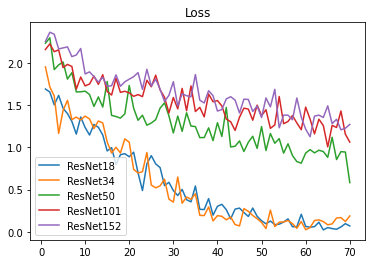

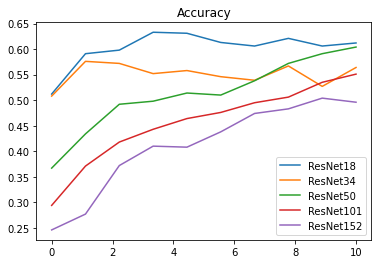

In [62]:
len_loss = len(loss_f18)
x_loss = np.linspace(1, len_loss, len_loss)
len_acc = len(acc_f18)
x_acc = np.linspace(0, len_acc, len_acc)

plt.figure()
plt.plot(x_loss, loss_f18, x_loss, loss_f34, x_loss, loss_f50,
         x_loss, loss_f101, x_loss, loss_f152)
plt.title('Loss')
plt.legend(['ResNet18', 'ResNet34', 'ResNet50', 
      'ResNet101', 'ResNet152'])
plt.figure()
plt.plot(x_acc, acc_f18, x_acc, acc_f34, x_acc, acc_f50,
         x_acc, acc_f101, x_acc, acc_f152)
plt.title('Accuracy')
plt.legend(['ResNet18', 'ResNet34', 'ResNet50', 
      'ResNet101', 'ResNet152'])
plt.show()